In [1]:
import numpyro
from Model.Energy import SineMultivariateVonMisesEnergy
from Model.Proposal import GaussianProposal, MultivariateVonMisesProposal, UniformProposal
from Data import get_dataloader_from_data
import matplotlib.pyplot as plt
import numpy as np
import torch 
from torch.utils.data import TensorDataset, DataLoader
from Model.Trainer import SNLTrainer

/opt/miniconda3/envs/lime_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Target Distribution 

In [2]:
phi = torch.tensor([0.0, np.pi/2, np.pi])
kappa = torch.tensor([4.0, 10.0, 1.0])

lam = torch.zeros((3,3))
lam[0,1] = 4.0
lam[0,2] = -4.0
lam[1,2] = 10.0
lam = (lam + lam.t())



target_distribution = MultivariateVonMisesProposal(input_size=torch.Size([3]), phi=phi, kappa=kappa, lam=lam)

Init Standard Gaussian...


In [3]:
target_sample = target_distribution.sample(10000)

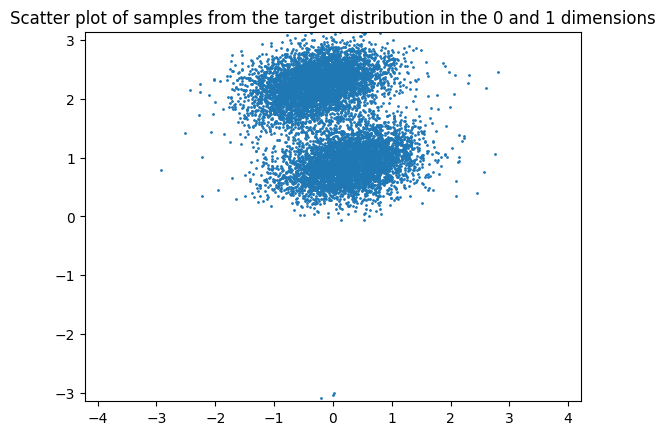

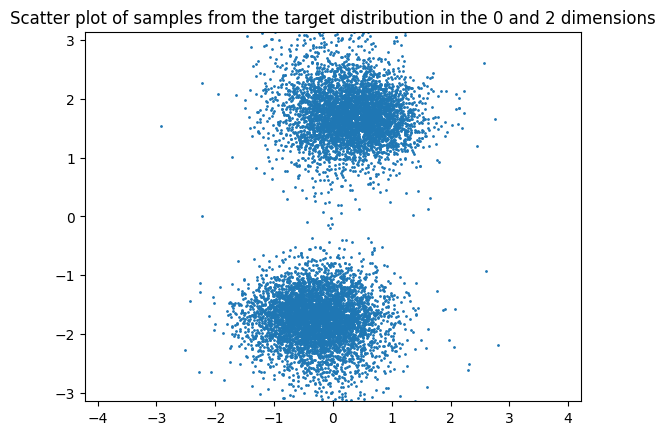

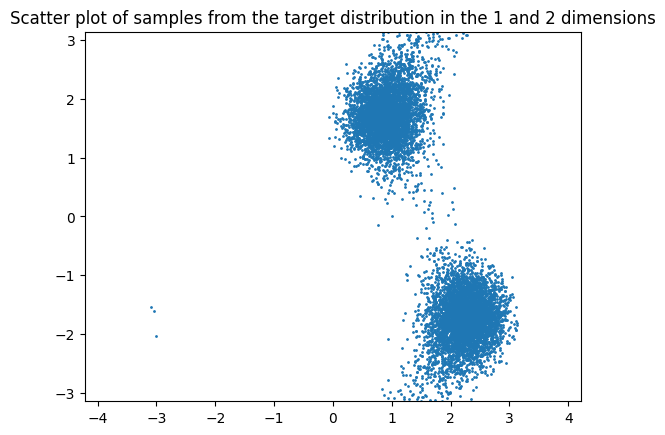

In [4]:
for i in range(3):
    for j in range(i+1, 3):
        plt.figure()
        plt.scatter(target_sample[:, i], target_sample[:, j], s=1)
        plt.axis('equal')
        plt.xlim(-np.pi, np.pi)
        plt.ylim(-np.pi, np.pi)
        plt.title(f"Scatter plot of samples from the target distribution in the {i} and {j} dimensions")
        plt.show()


data_train = get_dataloader_from_data(torch.from_numpy(target_sample.numpy()), batch_size=256)


# Proposal Distribution

In [5]:
proposal_distribution = GaussianProposal(input_size=torch.Size([3]), mu=torch.tensor([0.0, 0, 0]), sigma=torch.tensor([2.0, 2.0, 2.0]))
proposal_distribution = UniformProposal(input_size=torch.Size([3]), min=torch.tensor([-np.pi,-np.pi,-np.pi] ), max=torch.tensor([np.pi,np.pi,np.pi]))

Init Standard Gaussian...
Init Standard Gaussian...


tensor([[-1.0360,  1.6973,  0.1902],
        [ 0.3131,  2.1136,  1.1475],
        [-1.4211,  2.5559,  0.8238],
        ...,
        [ 2.2994, -0.5800,  1.4041],
        [-2.6300,  0.4423, -2.2613],
        [ 1.2859,  2.0788,  2.0554]])


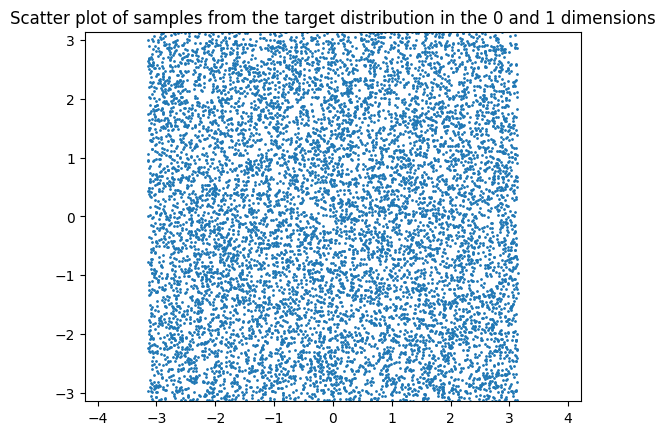

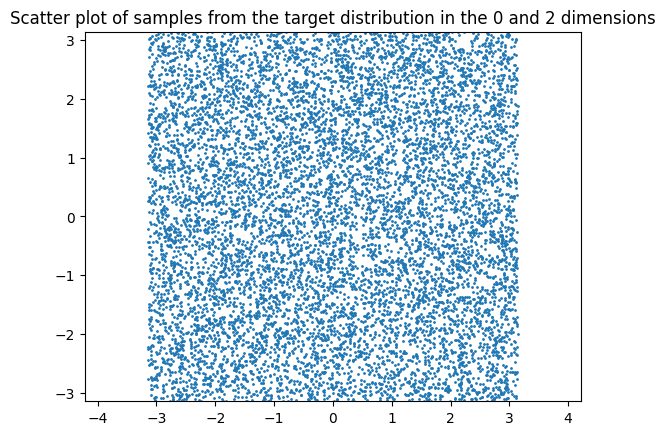

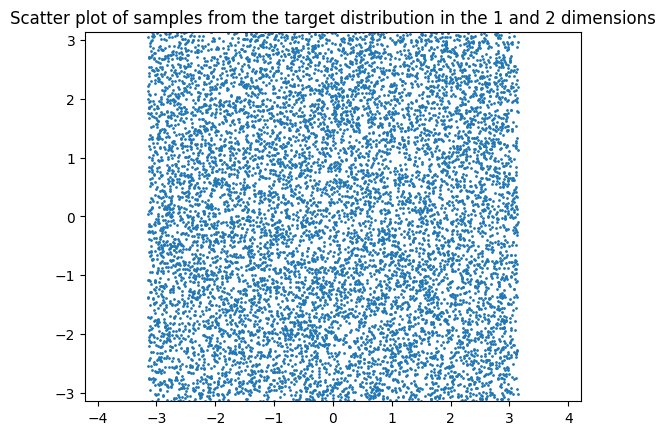

In [6]:
sample = proposal_distribution.sample(10000)
print(sample)

for i in range(3):
    for j in range(i+1, 3):
        plt.figure()
        plt.scatter(sample[:, i], sample[:, j], s=1)
        plt.axis('equal')
        plt.xlim(-np.pi, np.pi)
        plt.ylim(-np.pi, np.pi)
        plt.title(f"Scatter plot of samples from the target distribution in the {i} and {j} dimensions")
        plt.show()
        

# Energy 

In [7]:
energy_model = SineMultivariateVonMisesEnergy(dim=3, learn_theta=True, learn_kappa=True, learn_lambda=True)

In [8]:

target_sample = target_distribution.sample(10000)
mean, new_kappa, new_lam = energy_model.score_matching_estimator(target_sample)

print(phi)
print(mean)

print('=====')
print(kappa)
print(new_kappa)

print("=====")
print(lam)
print(new_lam)




tensor([0.2515+0.j, 0.1417+0.j, 0.0840+0.j, 1.0606+0.j, 0.8310+0.j, 0.7712+0.j])
tensor([0.0000, 1.5708, 3.1416])
tensor([0.0000, 1.5708, 3.1416])
=====
tensor([ 4., 10.,  1.])
tensor([3.6731, 6.6331, 0.8461])
=====
tensor([[ 0.,  4., -4.],
        [ 4.,  0., 10.],
        [-4., 10.,  0.]])
tensor([[ 0.0000,  7.2214, -4.7852],
        [ 7.2214,  0.0000,  7.0991],
        [-4.7852,  7.0991,  0.0000]])


In [10]:
target_sample = target_distribution.sample(10000)
mean, new_kappa, new_lam = energy_model.score_matching_estimator(target_sample)

print(phi)
print(mean)

print('=====')
print(kappa)
print(new_kappa)

print("=====")
print(lam)
print(new_lam)



tensor([0.2522+0.j, 0.1388+0.j, 0.0774+0.j, 1.0731+0.j, 0.7858+0.j, 0.8417+0.j])
tensor([0.0000, 1.5708, 3.1416])
tensor([0.0000, 1.5708, 3.1416])
=====
tensor([ 4., 10.,  1.])
tensor([3.7033, 7.1197, 0.8324])
=====
tensor([[ 0.,  4., -4.],
        [ 4.,  0., 10.],
        [-4., 10.,  0.]])
tensor([[ 0.0000,  7.7447, -5.2057],
        [ 7.7447,  0.0000,  7.7064],
        [-5.2057,  7.7064,  0.0000]])


In [11]:
target_sample = target_distribution.sample(10000)
mean, new_kappa, new_lam = energy_model.score_matching_estimator(target_sample)

print(phi)
print(mean)

print('=====')
print(kappa)
print(new_kappa)

print("=====")
print(lam)
print(new_lam)



tensor([0.2529+0.j, 0.1408+0.j, 0.0801+0.j, 1.0705+0.j, 0.7818+0.j, 0.8394+0.j])
tensor([0.0000, 1.5708, 3.1416])
tensor([0.0000, 1.5708, 3.1416])
=====
tensor([ 4., 10.,  1.])
tensor([3.6454, 6.9373, 0.8535])
=====
tensor([[ 0.,  4., -4.],
        [ 4.,  0., 10.],
        [-4., 10.,  0.]])
tensor([[ 0.0000,  7.4996, -4.9957],
        [ 7.4996,  0.0000,  7.4803],
        [-4.9957,  7.4803,  0.0000]])


# Trainer 

In [ ]:
trainer = SNLTrainer(energy_model, proposal_distribution, data_train, data_train, lr=1e-2)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hugosenetaire. Use `wandb login --relogin` to force relogin


In [ ]:
# energy_model.theta.data = phi
# energy_model.log_kappa.data = kappa
# energy_model.lam.data = lam

In [ ]:
trainer.train(n_iter = 200000, n_iter_pretrain= 1000)

Init Standard Gaussian...
Init Standard Gaussian...
Init Standard Gaussian...
Init Standard Gaussian...
Init Standard Gaussian...
Init Standard Gaussian...
Init Standard Gaussian...
Init Standard Gaussian...
Init Standard Gaussian...
Init Standard Gaussian...
Init Standard Gaussian...
Init Standard Gaussian...
Init Standard Gaussian...
Init Standard Gaussian...
Init Standard Gaussian...
Init Standard Gaussian...
Init Standard Gaussian...
Init Standard Gaussian...
Init Standard Gaussian...


KeyboardInterrupt: 

wandb: Network error (ConnectTimeout), entering retry loop.
